In [1]:
# imports

# python packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.font_manager
import rpy2
from functools import reduce
import xarray as xr

# rpy2 imports
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
from rpy2.ipython.ggplot import image_png
from rpy2.robjects import pandas2ri

# load rpy2 extension for ipython
pandas2ri.activate()
%load_ext rpy2.ipython

# stop showing SettingWithCopyWarning
pd.options.mode.chained_assignment = None


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.2
  warnings.warn(


In [2]:
# install & import r package sctransform

# check if sctransform is installed
if not ro.packages.isinstalled('sctransform'):
    # select CRAN mirror
    utils = importr('utils')
    utils.chooseCRANmirror(ind=1)
    # install sctransform
    utils.install_packages(ro.vectors.StrVector(['sctransform']))
    
# check if glmGamPoi is installed
if not ro.packages.isinstalled('glmGamPoi'):
    print('Please install glmGamPoi: https://github.com/const-ae/glmGamPoi')

# import sctransform
sctransform = importr('sctransform')
rmatrix = importr('Matrix')

# should be version 0.3.5 or higher                           
print(sctransform.__version__)


R[write to console]: trying URL 'https://cloud.r-project.org/bin/macosx/contrib/4.1/sctransform_0.3.5.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1203202 bytes (1.1 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[


The downloaded binary packages are in
	/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T//Rtmp0jNNX5/downloaded_packages
0.3.5


In [3]:
# helper functions

# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount

# function to convert pandas dataframe to r matrix
def pandas_dataframe_to_r_matrix(df, dtype=float):
    """
    Function to convert pandas DataFrame objects to R matrix objects.
    """
    if dtype is float:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    elif dtype is str:
        vector = ro.vectors.StrVector(df.values.flatten().tolist())
    elif dtype is int:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    else:
        raise ValueError('The dtype {} is not recognized'.format(dtype))
    matrix = rmatrix.Matrix(
        data=vector, 
        nrow=df.shape[0], 
        ncol=df.shape[1], 
        byrow=True, 
        dimnames=[df.index.to_list(), df.columns.to_list()], 
        sparse=True
    )
    return matrix


# Read in collated mapping counts and metadata

In [4]:
# read in metadata

# filepaths
filepath_genome_metadata = '../../data/metadata/genome_metadata.csv'
filepath_ortholog_metadata = '../../data/metadata/ortholog_metadata.csv'
filepath_sample_metadata = '../../data/metadata/sample_metadata.csv'

# genome metadata
genome_df = pd.read_csv(filepath_genome_metadata)

#  ortholog metadata
ortholog_df = pd.read_csv(filepath_ortholog_metadata)

#  sample metadata
sample_df = pd.read_csv(filepath_sample_metadata)
sample_df['Cruise'] = sample_df['Cruise'].map({'kok1606': 'G1', 
                                               'mgl1704': 'G2', 
                                               'km1906': 'G3'})
sample_df['samplename'] = [name[:-2] for name in sample_df['SampleID']]
sample_df = sample_df.rename(columns={'SampleID': 'sample', 'Replicate': 'replicate'})

# create annotations_df to map annotations back to orthologs
annotations_df = ortholog_df[['OrthologID', 'Annotation']].drop_duplicates()
annotations_df = annotations_df.rename(columns={'OrthologID': 'ortholog', 'Annotation': 'annotation'})

sample_df


,sample,Cruise,Dataset,Experiment,Station,Cast,Datetime,Latitude,Longitude,Depth,replicate,SmallFraction,LargeFraction,Unfractionated,Batch,samplename
0,G1.SURF.NS.S02C1.15m.A,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,A,G1.SURF.NS.S02C1.15m.0_2um.A,G1.SURF.NS.S02C1.15m.3um.A,False,G1_SURF,G1.SURF.NS.S02C1.15m
1,G1.SURF.NS.S02C1.15m.B,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,B,G1.SURF.NS.S02C1.15m.0_2um.B,G1.SURF.NS.S02C1.15m.3um.B,False,G1_SURF,G1.SURF.NS.S02C1.15m
2,G1.SURF.NS.S02C1.15m.C,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,C,G1.SURF.NS.S02C1.15m.0_2um.C,G1.SURF.NS.S02C1.15m.3um.C,False,G1_SURF,G1.SURF.NS.S02C1.15m
3,G1.SURF.NS.S04C1.15m.A,G1,Gradients 1 surface,NaN,4.0,1.0,4/22/16 5:40,28.143167,-158.000667,15,A,G1.SURF.NS.S04C1.15m.0_2um.A,G1.SURF.NS.S04C1.15m.3um.A,False,G1_SURF,G1.SURF.NS.S04C1.15m
4,G1.SURF.NS.S04C1.15m.B,G1,Gradients 1 surface,NaN,4.0,1.0,4/22/16 5:40,28.143167,-158.000667,15,B,G1.SURF.NS.S04C1.15m.0_2um.B,G1.SURF.NS.S04C1.15m.3um.B,False,G1_SURF,G1.SURF.NS.S04C1.15m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,G3.UW.NS.UW40_1.7m.B,G3,Gradients 3 underway,NaN,NaN,NaN,4/24/19 5:57,40.880000,-158.000000,7,B,G3.UW.NS.UW40_1.7m.0_2um.B,G3.UW.NS.UW40_1.7m.3um.B,False,G3_SURF,G3.UW.NS.UW40_1.7m
218,G3.UW.NS.UW40_1.7m.C,G3,Gradients 3 underway,NaN,NaN,NaN,4/24/19 5:57,40.880000,-158.000000,7,C,G3.UW.NS.UW40_1.7m.0_2um.C,G3.UW.NS.UW40_1.7m.3um.C,False,G3_SURF,G3.UW.NS.UW40_1.7m
219,G3.UW.NS.UW40_2.7m.A,G3,Gradients 3 underway,NaN,NaN,NaN,4/25/19 6:01,40.090000,-158.000000,7,A,G3.UW.NS.UW40_2.7m.0_2um.A,G3.UW.NS.UW40_2.7m.3um.A,False,G3_SURF,G3.UW.NS.UW40_2.7m
220,G3.UW.NS.UW40_2.7m.B,G3,Gradients 3 underway,NaN,NaN,NaN,4/25/19 6:01,40.090000,-158.000000,7,B,G3.UW.NS.UW40_2.7m.0_2um.B,G3.UW.NS.UW40_2.7m.3um.B,False,G3_SURF,G3.UW.NS.UW40_2.7m


In [5]:
# read in mapped transcript abundance data

filepath_data = '../../data/2-mapping/collated_salmon_data.csv.gz'
mappings_df = pd.read_csv(filepath_data)
mappings_df


,MappingName,GeneLength,TPM,NumReads,SampleID,GenomeName,GeneID
0,AG-311-D23_2717613068,360,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613068
1,AG-311-D23_2717613069,114,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613069
2,AG-311-D23_2717613070,1083,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613070
3,AG-311-D23_2717613071,1053,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613071
4,AG-311-D23_2717613072,1080,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613072
...,...,...,...,...,...,...,...
216275059,W9_2553539569,447,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539569
216275060,W9_2553539570,249,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539570
216275061,W9_2553539571,324,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539571
216275062,W9_2553539572,483,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539572


# Process mapped reads

- Drop reference genes without ortholog mapping (hypothesized to mostly be small RNA & other highly conserved RNA)
- Within each clade in each sample, aggregate reads mapping to the same ortholog


In [6]:
# directory to store output
output_dir = 'batch-test'


In [7]:
# collect reads mapping to known orthologs only and aggregate within orthologs

pangenome_df = mappings_df[['MappingName', 'SampleID', 'GenomeName', 'NumReads', 'GeneLength']]

# add genus, clade, and ortholog info to dataframe
pangenome_df['Genus'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Genus'])
pangenome_df['Clade'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Clade'])
pangenome_df['OrthologID'] = pangenome_df['MappingName'].map(ortholog_df.set_index('MappingName')['OrthologID'])

# down-select to only the genes with an ortholog mapping
pangenome_df = pangenome_df[~pangenome_df['OrthologID'].isna()]

# aggregate all orthologs in same genus
pangenome_df = pangenome_df.groupby(['SampleID', 'Genus', 'Clade', 
                                  'OrthologID']).agg(Reads=('NumReads', 'sum')).reset_index()

# identify nonzero mappings (at least one read mapped to ortholog-sample-clade)
pangenome_df['Nonzero'] = pangenome_df['Reads'].gt(0.0)

pangenome_df


,SampleID,Genus,Clade,OrthologID,Reads,Nonzero
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000001.0,79.000,True
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000002.0,64.000,True
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000003.0,18.000,True
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000004.0,1583.802,True
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000005.0,814.674,True
...,...,...,...,...,...,...
21847903,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040282.0,0.000,False
21847904,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040288.0,0.000,False
21847905,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040290.0,0.000,False
21847906,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040293.0,0.000,False


# Separate out data by clade

In [82]:
# separate out data for most highly represented clades in dataset

# thresholds
detection_min = 3 # minimum number of samples a gene must be detected in for each ecotype
coverage_threshold = 0.01 # minimum proportion of detected genes required for each sample included in ecotype subset
clades = {
    'pro': ['HLI', 'HLII', 'LLI'], 
    'syn': ['5.1A-I', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1B-VII', 'CDR2']
}

# storage variables
ortho_list = []
sample_list = []
core_df_dict = {}

for selected_clade in clades['pro'] + clades['syn']:
    print(selected_clade)
    clade_pangenome_df = pangenome_df[pangenome_df.Clade == selected_clade]
    clade_pangenome_df['Batch'] = clade_pangenome_df['SampleID'].map(sample_df.set_index('sample')['Batch'])
    
    # make fresh directory
    dir_path = '{}/{}'.format(output_dir, selected_clade)
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    # down-select data to detected orthologs
    core_df = pd.DataFrame(clade_pangenome_df.groupby('OrthologID').Nonzero.sum())
    core_df = core_df[core_df.Nonzero.gt(0)] # all detected orthologs
#     core_df = core_df[core_df.Nonzero.ge(detection_min)] # min number of samples
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.OrthologID.isin(core_df.index)]

    # down-select to only samples with coverage that is at least x% of the max coverage found in the dataset
    coverage = clade_pangenome_df.groupby('SampleID').Nonzero.sum()
    max_cov = coverage.max()
    total_orthos = len(core_df.index)
    print('Max coverage: {} / {} orthologs ({})'.format(max_cov, total_orthos, max_cov/total_orthos))
    samples = coverage[coverage.gt(coverage.max() * coverage_threshold)].index
    sample_list.append(samples)
    min_cov = coverage[samples].min()
    print('Min coverage: {} / {} orthologs ({})'.format(min_cov, total_orthos, min_cov/total_orthos))
    print('Total samples: {}\n'.format(len(samples)))
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df['SampleID'].isin(samples)]
    
    # down-select data to only orthologs that show up in a minimum number of samples in each batch
    core_df = pd.DataFrame(clade_pangenome_df.groupby(
        ['OrthologID', 'Batch']).Nonzero.sum().ge(detection_min).groupby('OrthologID').sum())
    core_df = core_df[core_df.Nonzero.gt(0)]
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.OrthologID.isin(core_df.index)]
    ortho_list.append(core_df.index)

    # pivot table
    clade_core_df = clade_pangenome_df.pivot(index='OrthologID', columns=['SampleID'], values='Reads')
    core_df_dict[selected_clade] = clade_core_df
    
    # save pre-normed data to csv
    clade_core_df.to_csv('{}/read_counts_{}.csv'.format(dir_path, selected_clade))
    

HLI
Max coverage: 2798 / 3843 orthologs (0.7280770231589904)
Min coverage: 28 / 3843 orthologs (0.007285974499089253)
Total samples: 175

HLII
Max coverage: 3418 / 4772 orthologs (0.7162615255658005)
Min coverage: 39 / 4772 orthologs (0.008172673931265717)
Total samples: 137

LLI
Max coverage: 3123 / 3587 orthologs (0.870643992194034)
Min coverage: 34 / 3587 orthologs (0.009478672985781991)
Total samples: 129

5.1A-I
Max coverage: 2569 / 3316 orthologs (0.7747285886610374)
Min coverage: 28 / 3316 orthologs (0.008443908323281062)
Total samples: 202

5.1A-II
Max coverage: 2940 / 3361 orthologs (0.8747396608152336)
Min coverage: 33 / 3361 orthologs (0.009818506396905683)
Total samples: 130

5.1A-III
Max coverage: 1881 / 2412 orthologs (0.7798507462686567)
Min coverage: 19 / 2412 orthologs (0.007877280265339967)
Total samples: 123

5.1A-IV
Max coverage: 3063 / 3390 orthologs (0.9035398230088496)
Min coverage: 32 / 3390 orthologs (0.00943952802359882)
Total samples: 207

5.1B-VII
Max covera

In [83]:
# look at intersections of samples and genes

# universal
print('Total cyanobacterial orthologs: {}'.format(len(reduce(np.union1d, ortho_list))))
print('Total cyanobacterial samples: {}'.format(len(reduce(np.union1d, sample_list))))
print('Shared cyanobacterial orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list))))
print('Shared cyanobacterial samples: {}\n'.format(len(reduce(np.intersect1d, sample_list))))

# pro
print('Total Pro orthologs: {}'.format(len(reduce(np.union1d, ortho_list[:3]))))
print('Total Pro samples: {}'.format(len(reduce(np.union1d, sample_list[:3]))))
print('Shared Pro orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list[:3]))))
print('Shared Pro samples: {}\n'.format(len(reduce(np.intersect1d, sample_list[:3]))))

# syn
print('Total Syn orthologs: {}'.format(len(reduce(np.union1d, ortho_list[3:]))))
print('Total Syn samples: {}'.format(len(reduce(np.union1d, sample_list[3:]))))
print('Shared Syn orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list[3:]))))
print('Shared Syn samples: {}\n'.format(len(reduce(np.intersect1d, sample_list[3:]))))


Total cyanobacterial orthologs: 9309
Total cyanobacterial samples: 222
Shared cyanobacterial orthologs: 1214
Shared cyanobacterial samples: 95

Total Pro orthologs: 5084
Total Pro samples: 178
Shared Pro orthologs: 1710
Shared Pro samples: 122

Total Syn orthologs: 6161
Total Syn samples: 222
Shared Syn orthologs: 1603
Shared Syn samples: 103



In [84]:
# count samples in each batch for each clade

batch_samples = {b: sample_df[sample_df['Batch'] == b]['sample'].tolist() for b in sample_df['Batch'].unique()}
for genus in ['pro', 'syn']:
    for clade in clades[genus]:
        print('\n{}'.format(clade))
        clade_core_df = core_df_dict[clade]
        for batch in sample_df['Batch'].unique():
            samples = [s for s in batch_samples[batch] if s in clade_core_df.columns]
            batch_df = clade_core_df[samples]
            print('\t{}: {} samples'.format(batch, batch_df.shape[1]))
            


HLI
	G1_SURF: 22 samples
	BEXP: 24 samples
	RR_DCM: 33 samples
	G2_SURF: 30 samples
	DEPTH_DIEL: 41 samples
	G3_SURF: 25 samples

HLII
	G1_SURF: 22 samples
	BEXP: 24 samples
	RR_DCM: 32 samples
	G2_SURF: 26 samples
	DEPTH_DIEL: 11 samples
	G3_SURF: 22 samples

LLI
	G1_SURF: 22 samples
	BEXP: 18 samples
	RR_DCM: 27 samples
	G2_SURF: 26 samples
	DEPTH_DIEL: 11 samples
	G3_SURF: 25 samples

5.1A-I
	G1_SURF: 16 samples
	BEXP: 24 samples
	RR_DCM: 43 samples
	G2_SURF: 28 samples
	DEPTH_DIEL: 66 samples
	G3_SURF: 25 samples

5.1A-II
	G1_SURF: 21 samples
	BEXP: 24 samples
	RR_DCM: 31 samples
	G2_SURF: 25 samples
	DEPTH_DIEL: 9 samples
	G3_SURF: 20 samples

5.1A-III
	G1_SURF: 18 samples
	BEXP: 24 samples
	RR_DCM: 29 samples
	G2_SURF: 24 samples
	DEPTH_DIEL: 9 samples
	G3_SURF: 19 samples

5.1A-IV
	G1_SURF: 18 samples
	BEXP: 25 samples
	RR_DCM: 43 samples
	G2_SURF: 30 samples
	DEPTH_DIEL: 66 samples
	G3_SURF: 25 samples

5.1B-VII
	G1_SURF: 20 samples
	BEXP: 17 samples
	RR_DCM: 32 samples
	G2_SU

# Normalize data using sctransform

* Save diagnostic plots & csv files, as well as tensorized data in NetCDF4 format

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1909

R[write to console]: Total overdispersed genes: 1905

R[write to console]: Excluding 4 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1909 by 22

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1905 genes, 22 cells



pro
HLI
  |======================================================================| 100%


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 3

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 4

R[write to console]: Calling offset model for all 4 poisson genes

R[write to console]: Found 8 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 4 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  7.28676036

R[write to console]: Second step: Get residuals using fitted parameters for 1909 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.096032 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2058

R[write to console]: Total overdispersed genes: 1967

R[write to console]: Excluding 91 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2058 by 24

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1967 genes, 24 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  18 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 18

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 91

R[write to console]: Calling offset model for all 91 poisson genes

R[write to console]: Found 18 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 91 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 2058 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.165017 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1999

R[write to console]: Total overdispersed genes: 1920

R[write to console]: Excluding 79 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1999 by 33

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1920 genes, 33 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  7 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 7

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 79

R[write to console]: Calling offset model for all 79 poisson genes

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 79 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 1999 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.189551 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3020

R[write to console]: Total overdispersed genes: 2885

R[write to console]: Excluding 135 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3020 by 30

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 30 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  24 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 24

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 135

R[write to console]: Calling offset model for all 135 poisson genes

R[write to console]: Found 28 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 135 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  70.55664004

R[write to console]: Second step: Get residuals using fitted parameters for 3020 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.338721 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2200

R[write to console]: Total overdispersed genes: 2176

R[write to console]: Excluding 24 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2200 by 41

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 41 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  82 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 82

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 24

R[write to console]: Calling offset model for all 24 poisson genes

R[write to console]: Found 96 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 24 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  12.96

R[write to console]: Second step: Get residuals using fitted parameters for 2200 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.169694 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2446

R[write to console]: Total overdispersed genes: 2377

R[write to console]: Excluding 69 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2446 by 25

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  56 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 56

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 69

R[write to console]: Calling offset model for all 69 poisson genes

R[write to console]: Found 57 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 69 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  15.99680016

R[write to console]: Second step: Get residuals using fitted parameters for 2446 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.263682 secs



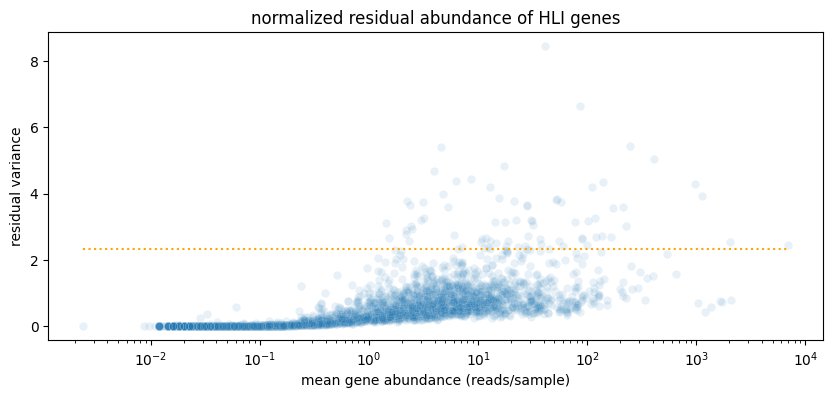

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2051

R[write to console]: Total overdispersed genes: 2044

R[write to console]: Excluding 7 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2051 by 22

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 22 cells



HLII
  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 7

R[write to console]: Calling offset model for all 7 poisson genes

R[write to console]: Found 4 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 7 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  21.15264064

R[write to console]: Second step: Get residuals using fitted parameters for 2051 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.092288 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2230

R[write to console]: Total overdispersed genes: 2164

R[write to console]: Excluding 66 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2230 by 24

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 24 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  19 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 19

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 66

R[write to console]: Calling offset model for all 66 poisson genes

R[write to console]: Found 19 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 66 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  4.84

R[write to console]: Second step: Get residuals using fitted parameters for 2230 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.093059 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 688

R[write to console]: Total overdispersed genes: 563

R[write to console]: Excluding 125 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 688 by 32

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 563 genes, 32 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 125

R[write to console]: Calling offset model for all 125 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 125 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.15952036

R[write to console]: Second step: Get residuals using fitted parameters for 688 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5428751 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3483

R[write to console]: Total overdispersed genes: 3285

R[write to console]: Excluding 198 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3483 by 26

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 26 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  53 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 53

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 198

R[write to console]: Calling offset model for all 198 poisson genes

R[write to console]: Found 53 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 198 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  4

R[write to console]: Second step: Get residuals using fitted parameters for 3483 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.141884 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1204

R[write to console]: Total overdispersed genes: 1110

R[write to console]: Excluding 94 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1204 by 11

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1110 genes, 11 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  134 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 134

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 94

R[write to console]: Calling offset model for all 94 poisson genes

R[write to console]: Found 134 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 94 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 1204 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.794801 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2554

R[write to console]: Total overdispersed genes: 2473

R[write to console]: Excluding 81 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2554 by 22

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 22 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  28 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 28

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 81

R[write to console]: Calling offset model for all 81 poisson genes

R[write to console]: Found 28 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 81 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.69

R[write to console]: Second step: Get residuals using fitted parameters for 2554 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.09544 secs



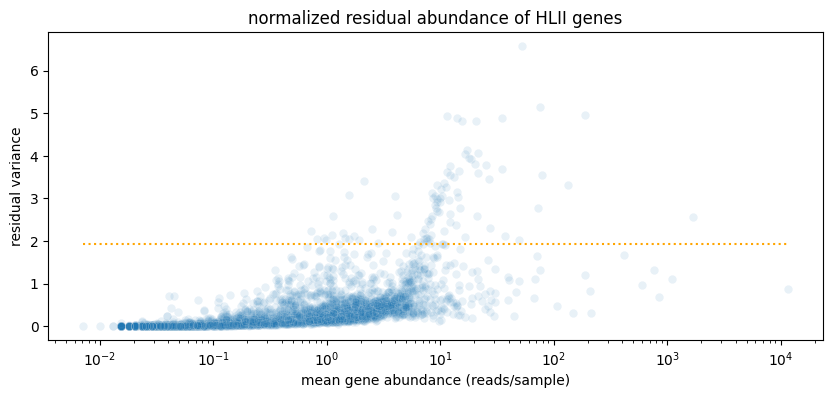

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 786

R[write to console]: Total overdispersed genes: 784

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 786 by 22

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 784 genes, 22 cells



LLI
  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Calling offset model for all 2 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 2 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.00040004

R[write to console]: Second step: Get residuals using fitted parameters for 786 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.601244 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 249

R[write to console]: Total overdispersed genes: 211

R[write to console]: Excluding 38 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 249 by 18

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 211 genes, 18 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  17 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 17

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 38

R[write to console]: Calling offset model for all 38 poisson genes

R[write to console]: Found 17 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 38 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 249 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.398885 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2745

R[write to console]: Total overdispersed genes: 2702

R[write to console]: Excluding 43 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2745 by 27

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 27 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  11 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 11

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 43

R[write to console]: Calling offset model for all 43 poisson genes

R[write to console]: Found 11 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 43 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  4.84

R[write to console]: Second step: Get residuals using fitted parameters for 2745 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.162739 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2150

R[write to console]: Total overdispersed genes: 2106

R[write to console]: Excluding 44 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2150 by 26

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 26 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  74 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 74

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 44

R[write to console]: Calling offset model for all 44 poisson genes

R[write to console]: Found 74 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 44 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 2150 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.148627 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1896

R[write to console]: Total overdispersed genes: 1863

R[write to console]: Excluding 33 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1896 by 11

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1863 genes, 11 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  68 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 68

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 33

R[write to console]: Calling offset model for all 33 poisson genes

R[write to console]: Found 68 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 33 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.96140025

R[write to console]: Second step: Get residuals using fitted parameters for 1896 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.156975 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1934

R[write to console]: Total overdispersed genes: 1872

R[write to console]: Excluding 62 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1934 by 25

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1872 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  90 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 90

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 62

R[write to console]: Calling offset model for all 62 poisson genes

R[write to console]: Found 91 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 62 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 1934 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.097471 secs



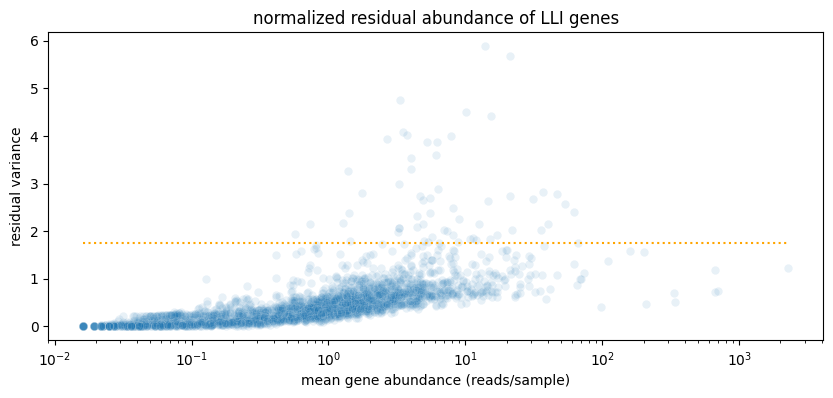

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1496

R[write to console]: Total overdispersed genes: 1491

R[write to console]: Excluding 5 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1496 by 16

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1491 genes, 16 cells



syn
5.1A-I
  |======================================================================| 100%


R[write to console]: Setting estimate of  6 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 6

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 5

R[write to console]: Calling offset model for all 5 poisson genes

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 5 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.96

R[write to console]: Second step: Get residuals using fitted parameters for 1496 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.971307 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 512

R[write to console]: Total overdispersed genes: 437

R[write to console]: Excluding 75 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 512 by 24

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 437 genes, 24 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  21 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 21

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 75

R[write to console]: Calling offset model for all 75 poisson genes

R[write to console]: Found 21 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 75 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 512 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4820209 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1779

R[write to console]: Total overdispersed genes: 1315

R[write to console]: Excluding 464 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1779 by 43

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1315 genes, 43 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  92 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 92

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 464

R[write to console]: Calling offset model for all 464 poisson genes

R[write to console]: Found 92 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 464 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.04

R[write to console]: Second step: Get residuals using fitted parameters for 1779 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.9037251 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2656

R[write to console]: Total overdispersed genes: 2567

R[write to console]: Excluding 89 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2656 by 28

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  153 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 153

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 89

R[write to console]: Calling offset model for all 89 poisson genes

R[write to console]: Found 153 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 89 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2656 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.14585 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2534

R[write to console]: Total overdispersed genes: 2417

R[write to console]: Excluding 117 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2534 by 66

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 66 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  15 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 15

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 117

R[write to console]: Calling offset model for all 117 poisson genes

R[write to console]: Found 15 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 117 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 2534 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.200602 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2536

R[write to console]: Total overdispersed genes: 2454

R[write to console]: Excluding 82 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2536 by 25

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  106 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 106

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 82

R[write to console]: Calling offset model for all 82 poisson genes

R[write to console]: Found 106 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 82 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 2536 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.206086 secs



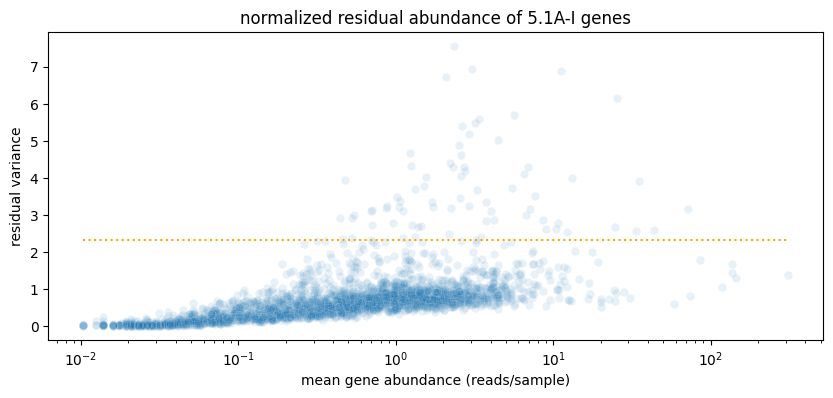

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2261

R[write to console]: Total overdispersed genes: 2260

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2261 by 21

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 21 cells



5.1A-II
  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  7.84

R[write to console]: Second step: Get residuals using fitted parameters for 2261 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.10644 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2176

R[write to console]: Total overdispersed genes: 2082

R[write to console]: Excluding 94 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2176 by 24

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 24 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  179 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 179

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 94

R[write to console]: Calling offset model for all 94 poisson genes

R[write to console]: Found 179 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 94 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2176 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.163201 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 198

R[write to console]: Total overdispersed genes: 152

R[write to console]: Excluding 46 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 198 by 31

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 152 genes, 31 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  6 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 6

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 46

R[write to console]: Calling offset model for all 46 poisson genes

R[write to console]: Found 6 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 46 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 198 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.362896 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2950

R[write to console]: Total overdispersed genes: 2887

R[write to console]: Excluding 63 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2950 by 25

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  121 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 121

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 63

R[write to console]: Calling offset model for all 63 poisson genes

R[write to console]: Found 124 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 63 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  5.76

R[write to console]: Second step: Get residuals using fitted parameters for 2950 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.197529 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 273

R[write to console]: Total overdispersed genes: 230

R[write to console]: Excluding 43 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 273 by 9

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 230 genes, 9 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  9 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 9

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 43

R[write to console]: Calling offset model for all 43 poisson genes

R[write to console]: Found 9 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 43 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 273 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.388835 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2170

R[write to console]: Total overdispersed genes: 2128

R[write to console]: Excluding 42 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2170 by 20

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 20 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  226 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 226

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 42

R[write to console]: Calling offset model for all 42 poisson genes

R[write to console]: Found 233 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 42 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 2170 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.425927 secs



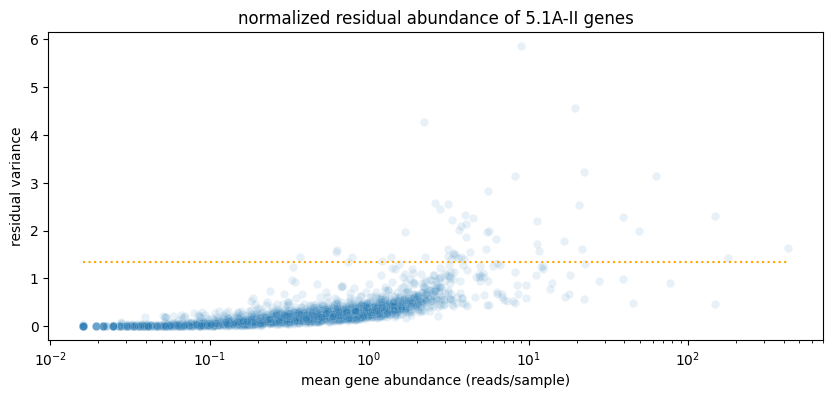

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1526

R[write to console]: Total overdispersed genes: 1515

R[write to console]: Excluding 11 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1526 by 18

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1515 genes, 18 cells



5.1A-III
  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 11

R[write to console]: Calling offset model for all 11 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 11 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.96

R[write to console]: Second step: Get residuals using fitted parameters for 1526 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.079294 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 906

R[write to console]: Total overdispersed genes: 783

R[write to console]: Excluding 123 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 906 by 24

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 783 genes, 24 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  38 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 38

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 123

R[write to console]: Calling offset model for all 123 poisson genes

R[write to console]: Found 39 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 123 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 906 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.6435909 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 115

R[write to console]: Total overdispersed genes: 86

R[write to console]: Excluding 29 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 115 by 29

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 86 genes, 29 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 29

R[write to console]: Calling offset model for all 29 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 29 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.04

R[write to console]: Second step: Get residuals using fitted parameters for 115 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3647859 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1964

R[write to console]: Total overdispersed genes: 1867

R[write to console]: Excluding 97 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1964 by 24

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1867 genes, 24 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  139 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 139

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 97

R[write to console]: Calling offset model for all 97 poisson genes

R[write to console]: Found 139 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 97 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 1964 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.132505 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 212

R[write to console]: Total overdispersed genes: 160

R[write to console]: Excluding 52 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 212 by 9

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 160 genes, 9 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  23 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 23

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 52

R[write to console]: Calling offset model for all 52 poisson genes

R[write to console]: Found 23 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 52 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.15992001

R[write to console]: Second step: Get residuals using fitted parameters for 212 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.409519 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1551

R[write to console]: Total overdispersed genes: 1464

R[write to console]: Excluding 87 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1551 by 19

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1464 genes, 19 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  141 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 141

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 87

R[write to console]: Calling offset model for all 87 poisson genes

R[write to console]: Found 143 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 87 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.25

R[write to console]: Second step: Get residuals using fitted parameters for 1551 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.9355991 secs



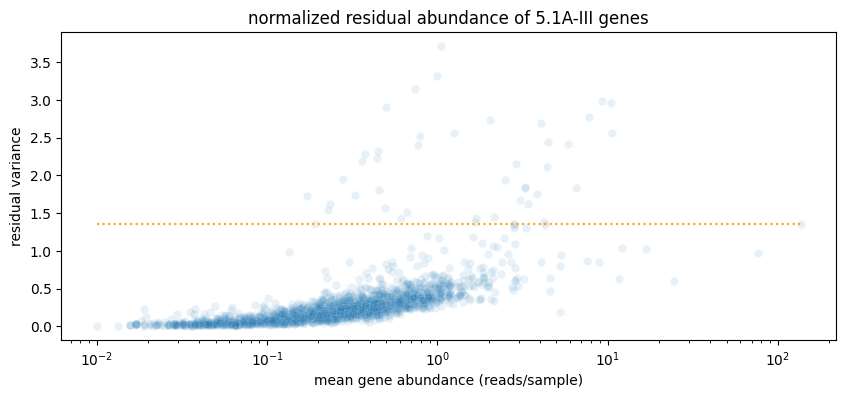

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2423

R[write to console]: Total overdispersed genes: 2422

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2423 by 18

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 18 cells



5.1A-IV
  |======================================================================| 100%


R[write to console]: Setting estimate of  7 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 7

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  19.36

R[write to console]: Second step: Get residuals using fitted parameters for 2423 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.262266 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1983

R[write to console]: Total overdispersed genes: 1876

R[write to console]: Excluding 107 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1983 by 25

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1876 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  164 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 164

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 107

R[write to console]: Calling offset model for all 107 poisson genes

R[write to console]: Found 166 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 107 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 1983 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.162465 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2592

R[write to console]: Total overdispersed genes: 2507

R[write to console]: Excluding 85 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2592 by 43

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 43 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  150 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 150

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 85

R[write to console]: Calling offset model for all 85 poisson genes

R[write to console]: Found 152 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 85 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 2592 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.264621 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3088

R[write to console]: Total overdispersed genes: 3047

R[write to console]: Excluding 41 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3088 by 30

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 30 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  62 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 62

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 41

R[write to console]: Calling offset model for all 41 poisson genes

R[write to console]: Found 63 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 41 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  12.96

R[write to console]: Second step: Get residuals using fitted parameters for 3088 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.18978 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2721

R[write to console]: Total overdispersed genes: 2646

R[write to console]: Excluding 75 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2721 by 66

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 66 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  23 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 23

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 75

R[write to console]: Calling offset model for all 75 poisson genes

R[write to console]: Found 23 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 75 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 2721 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.275095 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2793

R[write to console]: Total overdispersed genes: 2749

R[write to console]: Excluding 44 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2793 by 25

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  109 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 109

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 44

R[write to console]: Calling offset model for all 44 poisson genes

R[write to console]: Found 112 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 44 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  6.76

R[write to console]: Second step: Get residuals using fitted parameters for 2793 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.27265 secs



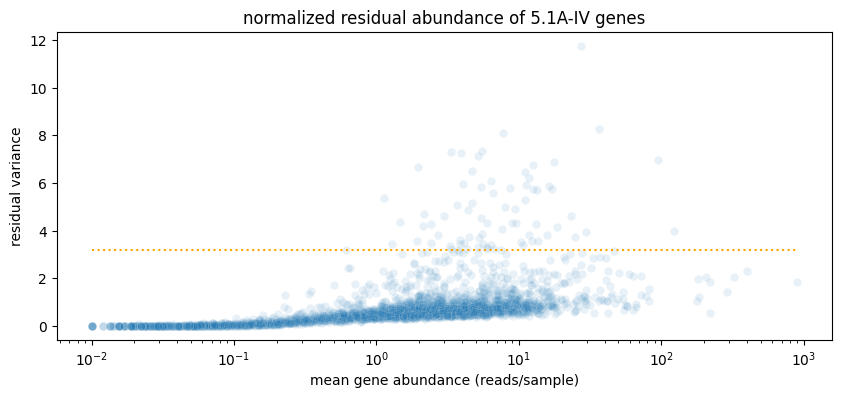

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2089

R[write to console]: Total overdispersed genes: 2087

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2089 by 20

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 20 cells



5.1B-VII
  |======================================================================| 100%


R[write to console]: Setting estimate of  17 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 17

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Calling offset model for all 2 poisson genes

R[write to console]: Found 17 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 2 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.56

R[write to console]: Second step: Get residuals using fitted parameters for 2089 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.122205 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2634

R[write to console]: Total overdispersed genes: 2544

R[write to console]: Excluding 90 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2634 by 17

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 17 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  159 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 159

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 90

R[write to console]: Calling offset model for all 90 poisson genes

R[write to console]: Found 159 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 90 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 2634 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.257373 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2960

R[write to console]: Total overdispersed genes: 2813

R[write to console]: Excluding 147 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2960 by 32

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 32 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  51 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 51

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 147

R[write to console]: Calling offset model for all 147 poisson genes

R[write to console]: Found 51 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 147 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 2960 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.252071 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3547

R[write to console]: Total overdispersed genes: 3468

R[write to console]: Excluding 79 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3547 by 28

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  68 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 68

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 79

R[write to console]: Calling offset model for all 79 poisson genes

R[write to console]: Found 69 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 79 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  5.76

R[write to console]: Second step: Get residuals using fitted parameters for 3547 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.20126 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1744

R[write to console]: Total overdispersed genes: 1656

R[write to console]: Excluding 88 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1744 by 29

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1656 genes, 29 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  211 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 211

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 88

R[write to console]: Calling offset model for all 88 poisson genes

R[write to console]: Found 230 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 88 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 1744 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.054479 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2599

R[write to console]: Total overdispersed genes: 2498

R[write to console]: Excluding 101 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2599 by 25

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  188 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 188

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 101

R[write to console]: Calling offset model for all 101 poisson genes

R[write to console]: Found 194 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 101 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2599 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.224445 secs



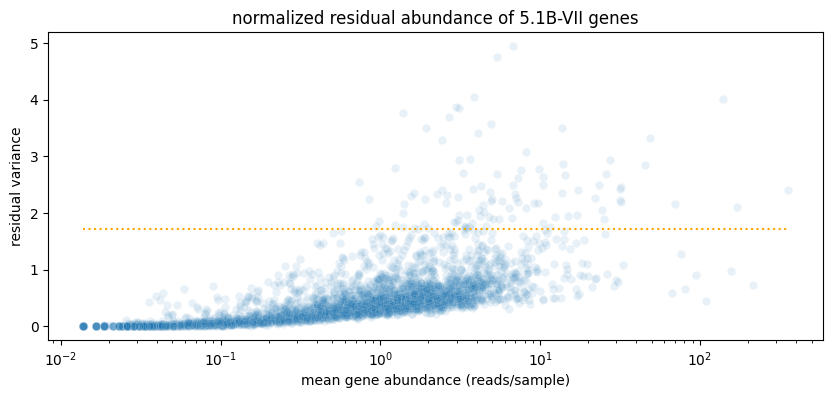

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1860

R[write to console]: Total overdispersed genes: 1855

R[write to console]: Excluding 5 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1860 by 22

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1855 genes, 22 cells



CDR2
  |======================================================================| 100%


R[write to console]: Setting estimate of  4 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 4

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 5

R[write to console]: Calling offset model for all 5 poisson genes

R[write to console]: Found 8 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 5 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 1860 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.096379 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2400

R[write to console]: Total overdispersed genes: 2345

R[write to console]: Excluding 55 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2400 by 24

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 24 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  154 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 154

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 55

R[write to console]: Calling offset model for all 55 poisson genes

R[write to console]: Found 156 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 55 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 2400 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.237989 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2515

R[write to console]: Total overdispersed genes: 2327

R[write to console]: Excluding 188 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2515 by 33

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 33 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  94 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 94

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 188

R[write to console]: Calling offset model for all 188 poisson genes

R[write to console]: Found 95 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 188 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2515 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.264513 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2928

R[write to console]: Total overdispersed genes: 2855

R[write to console]: Excluding 73 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2928 by 28

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  50 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 50

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 73

R[write to console]: Calling offset model for all 73 poisson genes

R[write to console]: Found 50 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 73 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  5.76

R[write to console]: Second step: Get residuals using fitted parameters for 2928 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.255879 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1773

R[write to console]: Total overdispersed genes: 1702

R[write to console]: Excluding 71 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1773 by 11

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1702 genes, 11 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  261 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 261

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 71

R[write to console]: Calling offset model for all 71 poisson genes

R[write to console]: Found 263 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 71 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 1773 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.225775 secs

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2428

R[write to console]: Total overdispersed genes: 2372

R[write to console]: Excluding 56 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2428 by 25

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  143 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 143

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 56

R[write to console]: Calling offset model for all 56 poisson genes

R[write to console]: Found 145 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 56 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 2428 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.186069 secs



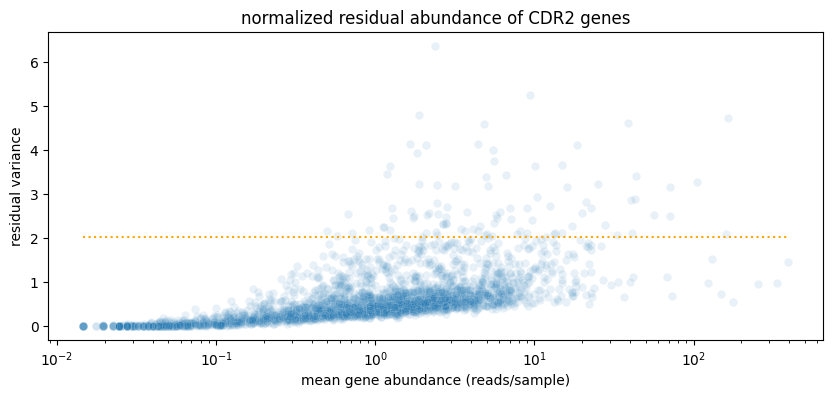

In [85]:
# run the model on each clade, saving outputs and plots

# store normalized data as slabs to arrange in xarray tensor
read_slabs = {}
residual_slabs = {}
batch_samples = {b: sample_df[sample_df['Batch'] == b]['sample'].tolist() for b in sample_df['Batch'].unique()}

# iterate through pro & syn
for genus in ['pro', 'syn']:
    print(genus)
    read_slabs[genus] = []
    residual_slabs[genus] = []
        
    # iterate through clades
    for clade in clades[genus]:
        print(clade)
        clade_core_df = core_df_dict[clade]
        residual_df = pd.DataFrame()

        # make fresh directory
        dir_path = '{}/{}'.format(output_dir, clade)
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
            
        # normalize each batch on its own
        for batch in sample_df['Batch'].unique():
            samples = [s for s in batch_samples[batch] if s in clade_core_df.columns]
            batch_df = clade_core_df[samples]
            # drop genes that fall below sample threshold in batch
            batch_df = batch_df[(batch_df != 0).sum(axis=1).ge(detection_min)]
            
            # skip over any without cells
            if len(batch_df) != 0:
                # convert batch_df to r matrix
                r_batch_df = pandas_dataframe_to_r_matrix(batch_df)

                # fit vst normalization model
                result = sctransform.vst(
                    r_batch_df, 
    #                 cell_attr=r_sample_attr_df, 
        #             batch_var=ro.vectors.StrVector(["Dataset"]),
        #             method='glmGamPoi', 
                    min_cells=detection_min,
                    return_gene_attr=True, 
                    return_cell_attr=True, 
                    vst_flavor='v2', 
                    verbosity=10
                )

                # save plot of model parameters
                plots = sctransform.plot_model_pars(result, show_theta=True)
                img = image_png(plots)
                with open('{}/parameters_{}.png'.format(dir_path, clade), 'wb') as png:
                    png.write(img.data)

                # convert residuals result to a dataframe
                result_df = pd.DataFrame(
                    np.asarray(result[0]), 
                    index=batch_df.index, 
                    columns=batch_df.columns
                )

                # add result to full clade residuals result
                if len(residual_df) == 0:
                    residual_df = result_df.copy()
                else:
                    residual_df = pd.merge(
                        residual_df, result_df, how='outer', left_index=True, right_index=True).fillna(0)

        # save residuals as csv
        residual_df.to_csv('{}/residuals_{}.csv'.format(dir_path, clade))
        
        # save residuals as slab 
        slab = (
            residual_df
            .reset_index()
            .rename(columns={'OrthologID': 'ortholog'})
            .melt(id_vars='ortholog', var_name='sample', value_name='residual')
        )
        slab['ortholog'] = slab['ortholog'].astype('Int64')
        slab['clade'] = clade
        residual_slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))
        
        # save read counts as slab 
        slab = (
            clade_core_df
            .reset_index()
            .rename(columns={'OrthologID': 'ortholog'})
            .melt(id_vars='ortholog', var_name='sample', value_name='readcount')
        )
        slab['ortholog'] = slab['ortholog'].astype('Int64')
        slab['clade'] = clade
        read_slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))

        # plot high variance genes
        residual_var = residual_df.var(axis=1)
        three_sigma = 1 + residual_var.var() * 3
        expression = clade_core_df.apply(geometric_mean, axis=1)
        plt.figure(figsize=(10, 4))
        sns.scatterplot(x=expression, y=residual_var, alpha=0.1);
        plt.hlines(three_sigma, expression.min(), expression.max(), 
                   colors=['orange'], linestyles=[':'], label='3*sigma');
        plt.xlabel('mean gene abundance (reads/sample)')
        plt.xscale('log')
        plt.ylabel('residual variance')
        plt.title('normalized residual abundance of {} genes'.format(clade))
        plt.savefig('{}/residual_variance_{}.png'.format(dir_path, clade))
        plt.show()

        # save csv of residual variances with annotations
        res_var_df = residual_var.reset_index().rename(columns={0:'ResidualVariance'})
        res_var_df['Annotation'] = res_var_df.OrthologID.map(annotations_df.set_index('ortholog')['annotation'])
        res_var_df = res_var_df.sort_values('ResidualVariance', ascending=False).reset_index()
        res_var_df.to_csv('{}/high_variance_orthologs_{}.csv'.format(dir_path, clade))
        
#         https://github.com/satijalab/seurat/issues/3720


In [86]:
# make slabs into xarray tensors and save

# make DataArrays for metadata
replicate_da = xr.DataArray.from_series(sample_df.set_index('sample')['replicate'])
samplename_da = xr.DataArray.from_series(sample_df.set_index('sample')['samplename'])
annotation_da = xr.DataArray.from_series(annotations_df.set_index('ortholog')['annotation'])

for genus in ['pro', 'syn']:
    # make read count DataArray
    read_data = read_slabs[genus]
    read_all_slabs = pd.concat(read_data)
    read_da = xr.DataArray.from_series(read_all_slabs['readcount']).fillna(0)
    # make residual DataArray
    residual_data = residual_slabs[genus]
    residual_all_slabs = pd.concat(residual_data)
    residual_da = xr.DataArray.from_series(residual_all_slabs['residual']).fillna(0)
    # combine residuals with metadata into xarray Dataset
    ds = xr.Dataset(
        dict(
            readcount=read_da, 
            residual=residual_da, 
            replicate=replicate_da.loc[residual_da.sample],
            samplename=samplename_da.loc[residual_da.sample], 
            annotation=annotation_da.loc[residual_da.ortholog]
        )
    )
    # save as netCDF4 file in data directory
    ds.to_netcdf('{}/{}-tensor-dataset.nc'.format(output_dir, genus))

ds
    

<xarray.Dataset>
Dimensions:     (ortholog: 6161, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) object 60000001 60000002 ... 60040219 60040245
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    residual    (ortholog, clade, sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    replicate   (sample) object 'A' 'B' 'C' 'A' 'B' 'C' ... 'B' 'C' 'A' 'B' 'C'
    samplename  (sample) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS.UW40_2.7m'
    annotation  (ortholog) object 'membrane protease FtsH catalytic subunit' ...